In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [8]:
data=pd.read_csv("crop_yield.csv")
data.columns

Index(['Crop', 'Crop_Year', 'Season', 'State', 'Area', 'Production',
       'Annual_Rainfall', 'Fertilizer', 'Pesticide', 'Yield'],
      dtype='object')

In [10]:
data.head()

,Crop,Crop_Year,Season,State,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Yield
0,Arecanut,1997,Whole Year,Assam,73814.0,56708,2051.4,7024878.38,22882.34,0.796087
1,Arhar/Tur,1997,Kharif,Assam,6637.0,4685,2051.4,631643.29,2057.47,0.710435
2,Castor seed,1997,Kharif,Assam,796.0,22,2051.4,75755.32,246.76,0.238333
3,Coconut,1997,Whole Year,Assam,19656.0,126905000,2051.4,1870661.52,6093.36,5238.051739
4,Cotton(lint),1997,Kharif,Assam,1739.0,794,2051.4,165500.63,539.09,0.420909


In [12]:
data.size

196890

In [15]:
data.describe()


,Crop_Year,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Yield
count,19689.000000,1.968900e+04,1.968900e+04,19689.000000,1.968900e+04,1.968900e+04,19689.000000
mean,2009.127584,1.799266e+05,1.643594e+07,1437.755177,2.410331e+07,4.884835e+04,79.954009
std,6.498099,7.328287e+05,2.630568e+08,816.909589,9.494600e+07,2.132874e+05,878.306193
min,1997.000000,5.000000e-01,0.000000e+00,301.300000,5.417000e+01,9.000000e-02,0.000000
25%,2004.000000,1.390000e+03,1.393000e+03,940.700000,1.880146e+05,3.567000e+02,0.600000
50%,2010.000000,9.317000e+03,1.380400e+04,1247.600000,1.234957e+06,2.421900e+03,1.030000
75%,2015.000000,7.511200e+04,1.227180e+05,1643.700000,1.000385e+07,2.004170e+04,2.388889
max,2020.000000,5.080810e+07,6.326000e+09,6552.700000,4.835407e+09,1.575051e+07,21105.000000


In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numeric_cols = ['Area', 'Production', 'Annual_Rainfall', 'Fertilizer', 'Pesticide']
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])


In [18]:
# strong_yield_pipeline.py
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

# ---------------------------
# 1) Load data
# ---------------------------
data = pd.read_csv("crop_yield.csv")   # change path if needed
X = data.drop(columns=["Yield"])
y = data["Yield"].values

# ---------------------------
# 2) Columns - adjust if your DF differs
# ---------------------------
numeric_skewed = ["Production"]   # apply log1p to reduce huge outliers like Coconut
numeric_plain  = ["Area", "Annual_Rainfall", "Fertilizer", "Pesticide", "Crop_Year"]
categorical_cols = ["Crop", "Season", "State"]

# if Crop_Year isn't numeric in your file, convert:
if "Crop_Year" in X.columns:
    X["Crop_Year"] = pd.to_numeric(X["Crop_Year"], errors="coerce")

# ---------------------------
# 3) Preprocessing pipeline
# ---------------------------
log_tf = FunctionTransformer(np.log1p, validate=False)

num_skew_pipe = Pipeline([
    ("log", log_tf),
    ("scaler", StandardScaler())
])

num_pipe = Pipeline([
    ("scaler", StandardScaler())
])

cat_pipe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

preprocessor = ColumnTransformer([
    ("prod_skew", num_skew_pipe, [c for c in numeric_skewed if c in X.columns]),
    ("num", num_pipe, [c for c in numeric_plain if c in X.columns]),
    ("cat", cat_pipe, [c for c in categorical_cols if c in X.columns])
], remainder="drop")

# ---------------------------
# 4) Choose strong base learners (use what's installed)
# ---------------------------
base_estimators = []
# try LightGBM
try:
    from lightgbm import LGBMRegressor
    base_estimators.append(("lgb", LGBMRegressor(random_state=42, n_estimators=400, n_jobs=-1)))
except Exception:
    pass

# try XGBoost
try:
    from xgboost import XGBRegressor
    base_estimators.append(("xgb", XGBRegressor(random_state=42, n_estimators=400, verbosity=0, tree_method="hist")))
except Exception:
    pass

# fallback powerful sklearn models
base_estimators.append(("hgb", HistGradientBoostingRegressor(random_state=42, max_iter=400)))
base_estimators.append(("rf", RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)))

# final estimator for stacking (you can try a stronger one if available)
final_estimator = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)

stack = StackingRegressor(estimators=base_estimators, final_estimator=final_estimator, passthrough=True, n_jobs=-1)

# ---------------------------
# 5) Full pipeline with target transform
# ---------------------------
# Transform the target with log1p (good for skewed positive targets)
tt = TransformedTargetRegressor(regressor=stack, func=np.log1p, inverse_func=np.expm1)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", tt)
])

# ---------------------------
# 6) Cross-validated evaluation (gives a realistic error estimate)
# ---------------------------
cv = KFold(n_splits=5, shuffle=True, random_state=42)

print("Running cross-validated predictions (this may take time)...")
y_pred = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1)

rmse = np.sqrt(mean_squared_error(y, y_pred))
mae  = mean_absolute_error(y, y_pred)
r2   = r2_score(y, y_pred)

print(f"CV RMSE: {rmse:.4f}")
print(f"CV MAE : {mae:.4f}")
print(f"CV R2  : {r2:.4f}")

# ---------------------------
# 7) Fit on full data & save model
# ---------------------------
print("Fitting final model on the whole dataset...")
pipeline.fit(X, y)

joblib.dump(pipeline, "yield_model_stack.pkl")
print("Saved model to yield_model_stack.pkl")

# ---------------------------
# 8) Optional: feature importance via permutation (after fit)
# ---------------------------
try:
    from sklearn.inspection import permutation_importance
    Xi = pipeline.named_steps["preprocessor"].transform(X)
    res = permutation_importance(pipeline.named_steps["regressor"], Xi, y, n_repeats=10, random_state=42, n_jobs=-1)
    # mapping importance back to feature names is a bit involved because of OHE; here's a quick sanity print:
    print("Permutation importances (mean):", res.importances_mean[:10])
except Exception as e:
    print("Permutation importance skipped (error):", e)


Running cross-validated predictions (this may take time)...
CV RMSE: 137.3845
CV MAE : 7.7298
CV R2  : 0.9755
Fitting final model on the whole dataset...
Saved model to yield_model_stack.pkl


C:\Users\navas\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\navas\AppData\Roaming\Python\Python313\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Permutation importance skipped (error): [WinError 1450] Insufficient system resources exist to complete the requested service


In [1]:
# ---------------------------
# 4) Choose strong base learners (fixed warnings)
# ---------------------------
base_estimators = []
# try LightGBM
try:
    from lightgbm import LGBMRegressor
    base_estimators.append(("lgb", LGBMRegressor(random_state=42, n_estimators=200, n_jobs=1)))  # n_jobs=1 to reduce worker crash
except Exception:
    pass

# try XGBoost
try:
    from xgboost import XGBRegressor
    base_estimators.append(("xgb", XGBRegressor(random_state=42, n_estimators=200, verbosity=0, tree_method="hist", n_jobs=1)))
except Exception:
    pass

# fallback powerful sklearn models
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
base_estimators.append(("hgb", HistGradientBoostingRegressor(random_state=42, max_iter=200)))  # HGB uses all cores internally
base_estimators.append(("rf", RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=1)))  # n_jobs=1

# final estimator for stacking
final_estimator = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=1)


In [2]:
import joblib
import pandas as pd

pipeline = joblib.load("yield_model_stack.pkl")


In [3]:
# Example new data
new_data = pd.DataFrame({
    "Crop": ["Coconut"],
    "Crop_Year": [2025],
    "Season": ["Whole Year"],
    "State": ["Assam"],
    "Area": [20000],
    "Production": [130000000],
    "Annual_Rainfall": [2100],
    "Fertilizer": [1800000],
    "Pesticide": [6000]
})


In [4]:
predicted_yield = pipeline.predict(new_data)
print("Predicted Yield:", predicted_yield[0])


C:\Users\navas\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Predicted Yield: 43.47321825001192


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

# 1️⃣ Load your saved pipeline
pipeline = joblib.load("yield_model_stack.pkl")

# 2️⃣ Load data
data = pd.read_csv("crop_yield.csv")
X = data.drop(columns=["Yield"])
y = data["Yield"].values

# 3️⃣ Split data into train and test (hold-out)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4️⃣ Fit pipeline on training data
pipeline.fit(X_train, y_train)

# 5️⃣ Predict on training and test set
y_train_pred = pipeline.predict(X_train)
y_test_pred  = pipeline.predict(X_test)

# 6️⃣ Compute metrics
def print_metrics(true, pred, name=""):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae  = mean_absolute_error(true, pred)
    r2   = r2_score(true, pred)
    print(f"{name} -> RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.4f}")

print_metrics(y_train, y_train_pred, "Train")
print_metrics(y_test, y_test_pred, "Test")


C:\Users\navas\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\navas\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Train -> RMSE: 80.25, MAE: 3.29, R2: 0.9916
Test -> RMSE: 102.11, MAE: 6.21, R2: 0.9870


C:\Users\navas\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


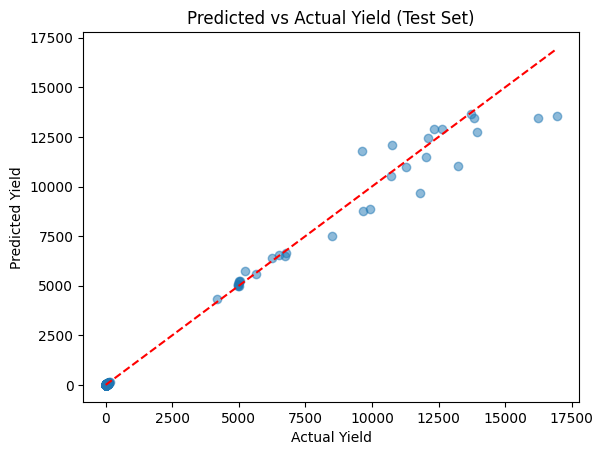

In [7]:
import matplotlib.pyplot as plt

y_test_pred = pipeline.predict(X_test)

plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # perfect prediction line
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title("Predicted vs Actual Yield (Test Set)")
plt.show()

